In [1]:

# Task 1: Image Processing Techniques
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction import image
import os
from scipy import ndimage
import glob

In [2]:
# ===================== IMAGE INPAINTING =====================
def remove_noise_with_inpainting(image_path, output_path):
    """
    Remove noise from an image using inpainting
    """
    # Read the image
    img = cv2.imread(image_path)
    
    # Convert to grayscale for noise detection
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Threshold to identify noise (adjust threshold as needed)
    _, noise_mask = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY)
    
    # Dilate to ensure complete noise coverage
    kernel = np.ones((3, 3), np.uint8)
    noise_mask = cv2.dilate(noise_mask, kernel, iterations=1)
    
    # Apply inpainting
    result = cv2.inpaint(img, noise_mask, 3, cv2.INPAINT_TELEA)
    
    # Save result
    cv2.imwrite(output_path, result)
    
    # Display results for comparison
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title('Original Image with Noise')
    
    plt.subplot(1, 3, 2)
    plt.imshow(noise_mask, cmap='gray')
    plt.title('Noise Mask')
    
    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    plt.title('Image After Inpainting')
    
    plt.tight_layout()
    plt.show()
    
    return result

In [5]:
# ================== IMAGE & PANORAMA STITCHING ==================
def stitch_images(images_folder, output_path):
    """
    Stitch multiple images together to create a panorama
    """
    # Read images
    image_paths = glob.glob(os.path.join(images_folder, '*.jpg'))
    images = []
    
    for image_path in image_paths:
        img = cv2.imread(image_path)
        images.append(img)
    
    # Create stitcher object
    stitcher = cv2.Stitcher_create()
    
    # Stitch images
    status, stitched_img = stitcher.stitch(images)
    
    if status == cv2.Stitcher_OK:
        # Save the stitched image
        cv2.imwrite(output_path, stitched_img)
        
        # Display the result
        plt.figure(figsize=(15, 10))
        plt.imshow(cv2.cvtColor(stitched_img, cv2.COLOR_BGR2RGB))
        plt.title('Stitched Panorama')
        plt.axis('off')
        plt.show()
        
        return stitched_img
    else:
        print(f"Stitching failed with error code {status}")
        return None

In [3]:
# ================== STRUCTURE FROM MOTION ==================
def structure_from_motion(image1_path, image2_path):
    """
    Implement basic structure from motion using two images
    """
    # Read images
    img1 = cv2.imread(image1_path, cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(image2_path, cv2.IMREAD_GRAYSCALE)
    
    # Feature detection (SIFT)
    sift = cv2.SIFT_create()
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)
    
    # Feature matching using FLANN
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1, des2, k=2)
    
    # Apply Lowe's ratio test
    good_matches = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good_matches.append(m)
    
    # Extract matched keypoints
    pts1 = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    pts2 = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    
    # Find fundamental matrix
    F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC, 3.0)
    
    # Select only inlier points
    pts1 = pts1[mask.ravel() == 1]
    pts2 = pts2[mask.ravel() == 1]
    
    # Camera intrinsic parameters (assumed)
    focal_length = 1000
    principal_point = (img1.shape[1] / 2, img1.shape[0] / 2)
    K = np.array([
        [focal_length, 0, principal_point[0]],
        [0, focal_length, principal_point[1]],
        [0, 0, 1]
    ])
    
    # Calculate essential matrix
    E = K.T @ F @ K
    
    # Recover pose (rotation and translation)
    _, R, t, _ = cv2.recoverPose(E, pts1, pts2, K)
    
    # Print camera motion information
    print("Rotation matrix:")
    print(R)
    print("\nTranslation vector:")
    print(t)
    
    # Visualize matched features
    img_matches = cv2.drawMatches(img1, kp1, img2, kp2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.figure(figsize=(15, 8))
    plt.imshow(img_matches)
    plt.title('Feature Matches Between Images')
    plt.show()
    
    return R, t, pts1, pts2


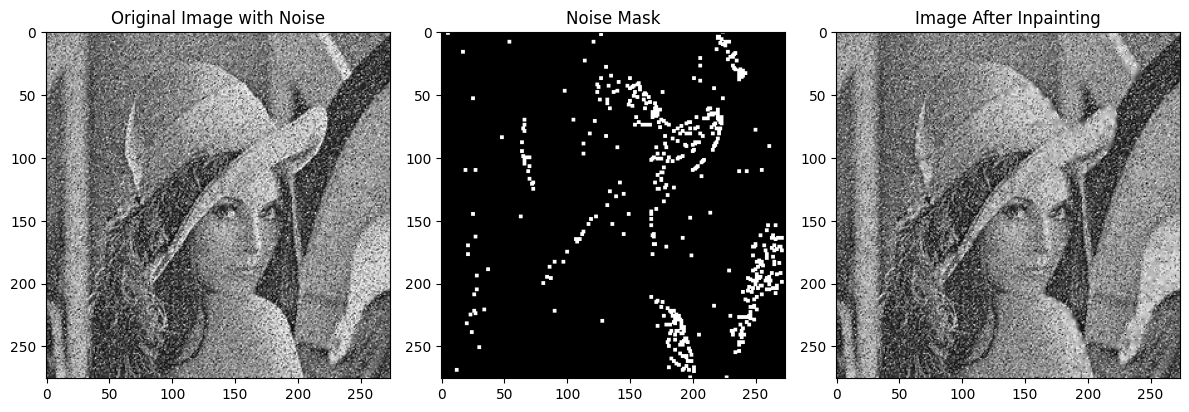

Stitching failed with error code 1
Rotation matrix:
[[ 0.99059486 -0.10144145  0.09182291]
 [ 0.09984778  0.99476392  0.02179834]
 [-0.09355338 -0.01242501  0.99553673]]

Translation vector:
[[-0.51503009]
 [-0.07609258]
 [-0.85378799]]


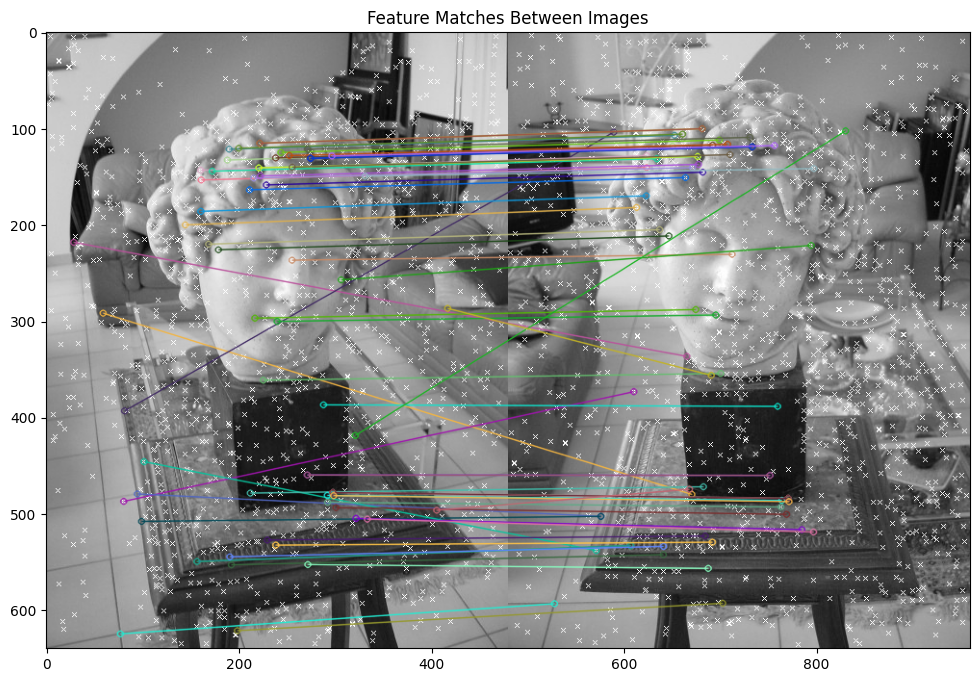

In [7]:
# 1. Image Inpainting
remove_noise_with_inpainting('noisy_img.jpeg', 'inpainted_image.jpg')

# 2. Image Stitching
stitch_images('panorama_images_folder', 'panorama_result.jpg')

# 3. Structure from Motion
R, t, pts1, pts2 = structure_from_motion('feature4.jpg', 'feature5.jpg')